<a href="https://colab.research.google.com/github/OleksiiLatypov/mlzoomcamp-midterm-project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, fbeta_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import pickle

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [4]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
!wget https://raw.githubusercontent.com/OleksiiLatypov/mlzoomcamp-midterm-project/refs/heads/main/final_depression_dataset_1.csv

--2024-11-20 12:51:16--  https://raw.githubusercontent.com/OleksiiLatypov/mlzoomcamp-midterm-project/refs/heads/main/final_depression_dataset_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-11-20 12:51:16 ERROR 404: Not Found.



In [18]:
df_train = pd.read_csv('/content/train.csv')
df_original = pd.read_csv('/content/final_depression_dataset_1.csv')

 Checking the 3 rows of the train_dataset dataset

In [19]:
df_train.head(3)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1


 Checking the first 3 rows of the original dataset

In [20]:
df_original.head(3)

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No


* Inconsistent Data: My train data contains unneccessery column ***id***.

* ***depression*** column has the object data type (which means it's treated as a string), but it should be a numeric or categorical variable for classification tasks.

Drop the ***id*** column from the training dataset since it is an identifier

In [21]:
df_train = df_train.drop('id', axis=1)

Standardize column names by:
1. Converting all column names to lowercase for uniformity, ensuring that
    column names are case-insensitive, which is especially useful in case
    any of the column names have mixed case (e.g., 'Age' vs. 'age').
2. Replacing any spaces (' ') in column names with underscores ('_') to
    make the column names more readable and easier to work with,
    as spaces can cause issues in some operations (e.g., when referencing
    columns programmatically).
These operations help make the column names consistent and accessible
throughout the analysis or modeling process.

In [22]:
df_train.columns = df_train.columns.str.lower().str.replace(' ', '_').str.replace('_?', '')
df_original.columns = df_original.columns.str.lower().str.replace(' ', '_').str.replace('_?', '')

Convert the ***depression*** column from categorical strings ('Yes', 'No') to binary integers (1, 0).

In [23]:
df_original['depression'] = (df_original['depression'] == 'Yes').astype('int')

Concatenate the ***df_train*** and ***df_original***  DataFrames along the rows (axis=0) to combine the datasets.

In [24]:
df = pd.concat([df_train, df_original], axis=0, ignore_index=True)

Checking the first 3 rows of the joined dataset

In [25]:
df.head(3)

,name,gender,age,city,working_professional_or_student,profession,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work/study_hours,financial_stress,family_history_of_mental_illness,depression
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1


Checking dataset imbalance ratio

In [26]:
negative_depression = df[df['depression'] == 0].shape[0]
positive_depression = df[df['depression'] == 1].shape[0]
imbalanced_ratio = 100 * (positive_depression / negative_depression)
np.round(imbalanced_ratio)

22.0

Imbalance ratio is 22%. It is moderate value ratio.

In [27]:
df.shape

(143256, 19)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143256 entries, 0 to 143255
Data columns (total 19 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   name                                 143256 non-null  object 
 1   gender                               143256 non-null  object 
 2   age                                  143256 non-null  float64
 3   city                                 143256 non-null  object 
 4   working_professional_or_student      143256 non-null  object 
 5   profession                           105953 non-null  object 
 6   academic_pressure                    28399 non-null   float64
 7   work_pressure                        114836 non-null  float64
 8   cgpa                                 28400 non-null   float64
 9   study_satisfaction                   28399 non-null   float64
 10  job_satisfaction                     114844 non-null  float64
 11  sleep_duratio

Several columns have missing values (e.g., profession, academic_pressure, cgpa).
Dataset contains 10 categorical features and 9 numerical features.

Checking duplicates in dataset.

In [29]:
df.duplicated().sum()

0

There is no duplicates in dataset

Checking descriptive statistics of dataset

In [30]:
df.describe()

,age,academic_pressure,work_pressure,cgpa,study_satisfaction,job_satisfaction,work/study_hours,financial_stress,depression
count,143256.000000,28399.000000,114836.000000,28400.000000,28399.000000,114844.000000,143256.000000,143252.000000,143256.000000
mean,40.364613,3.139829,2.999408,7.657031,2.947252,2.975131,6.248597,2.988621,0.181647
std,12.383146,1.380722,1.405975,1.464505,1.360518,1.416124,3.852275,1.413664,0.385555
min,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


In [31]:
df.describe(include=['object'])

,name,gender,city,working_professional_or_student,profession,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,family_history_of_mental_illness
count,143256,143256,143256,143256,105953,143256,143252,143254,143256,143256
unique,422,2,98,2,64,36,23,115,2,2
top,Rohan,Male,Kalyan,Working Professional,Teacher,Less than 5 hours,Moderate,Class 12,No,No
freq,3204,78797,6683,114853,25228,39432,50537,15004,72445,72069


Checking the percentage of missing (null) values for each column in the dataset:

In [32]:
percent_missing = (df.isnull().sum() / df.shape[0]) * 100
percent_missing.sort_values(ascending=False)


,0
study_satisfaction,80.176048
academic_pressure,80.176048
cgpa,80.175350
profession,26.039398
work_pressure,19.838611
job_satisfaction,19.833026
dietary_habits,0.002792
financial_stress,0.002792
degree,0.001396
family_history_of_mental_illness,0.000000


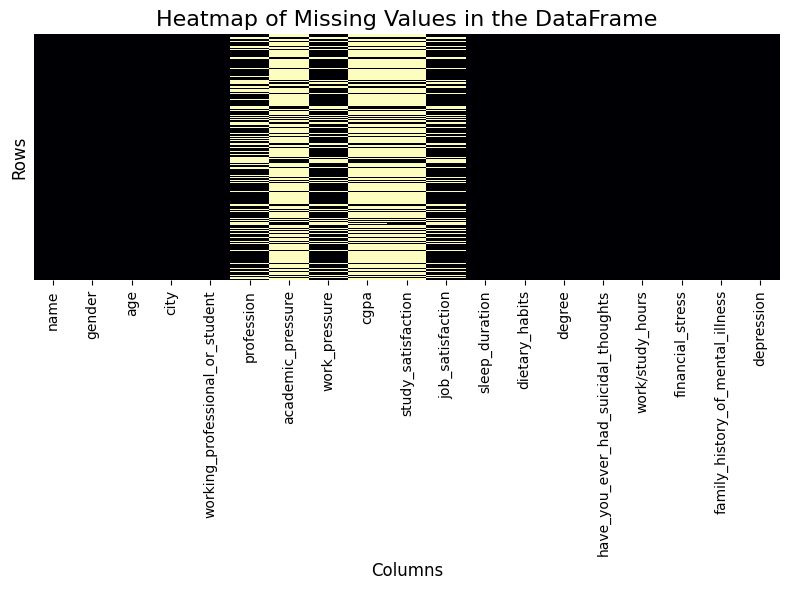

In [ ]:
missing_data = df.isnull()

# Create a heatmap to visualize missing data
plt.figure(figsize=(8, 6))
sns.heatmap(missing_data, cbar=False, cmap="magma", yticklabels=False)
plt.title("Heatmap of Missing Values in the DataFrame", fontsize=16)
plt.xlabel("Columns", fontsize=12)
plt.ylabel("Rows", fontsize=12)
plt.tight_layout()
plt.show()

***study_satisfaction***, ***academic_pressure***, and ***cgpa*** have approximately 80% missing. Given that the columns ***study_satisfaction***, ***academic_pressure***, and ***cgpa*** have approximately 80% missing data, dropping them is a practical decision. This high level of missingness can significantly impact the reliability and validity of your analysis.:

In [33]:
df = df.drop(['study_satisfaction', 'academic_pressure', 'cgpa'], axis=1)

Checking and identify the categorical columns in the dataset and print the number of unique values for each of them:

In [34]:
categorical_features = df.select_dtypes(include=['object', 'category'])
for col in categorical_features.columns:
  print(f'{col} has {df[col].nunique()} unique values')

name has 422 unique values
gender has 2 unique values
city has 98 unique values
working_professional_or_student has 2 unique values
profession has 64 unique values
sleep_duration has 36 unique values
dietary_habits has 23 unique values
degree has 115 unique values
have_you_ever_had_suicidal_thoughts has 2 unique values
family_history_of_mental_illness has 2 unique values


***gender***, ***working_professional_or_student***, ***have_you_ever_had_suicidal_thoughts***, and family_history_of_mental_illness each have only 2 unique values (binary features).

***name*** has **422 unique** values, which likely corresponds to individual names. Since it's unlikely that names will have predictive value for depression (and likely represents a non-informative variable), it is a good candidate for removal. The same logic applies to ***city*** column, which has **98 unique** values. While geographical location can sometimes influence mental health (e.g., urban vs. rural stressors).

In [35]:
df = df.drop(['name', 'city'], axis=1)

In [36]:
res = {}
categorical_features = df.select_dtypes(include=['object', 'category'])
for col in categorical_features.columns:
    res[f'Column_{col}'] = df[col].unique()
res

{'Column_gender': array(['Female', 'Male'], dtype=object),
 'Column_working_professional_or_student': array(['Working Professional', 'Student'], dtype=object),
 'Column_profession': array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
        'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
        'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
        'HR Manager', 'UX/UI Designer', 'Content Writer',
        'Educational Consultant', 'Civil Engineer', 'Manager',
        'Pharmacist', 'Financial Analyst', 'Architect',
        'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
        'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
        'Digital Marketer', 'Lawyer', 'Research Analyst',
        'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
        'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
        'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
      

It looks like there are some strange or inconsistent entries in the ***sleep_duration***, ***degree***, and ***dietary_habits*** columns, which might be impacting the quality of your data for analysis. Let's go through each of these columns and identify the issues and possible solutions:

 Filter and clean ***sleep_duration***, ***dietary_habits*** columns based on valid categories to handle inconsistent or incorrect data. By marking invalid entries as 'Noise'. It is standardizing the data and making sure that only meaningful values are retained. This can help ensure that the model won't be misled by unexpected or erroneous values.

In [37]:
df_original['sleep_duration'].value_counts()

,count
sleep_duration,
7-8 hours,658
Less than 5 hours,648
5-6 hours,628
More than 8 hours,622


In [38]:
def clean_columns(df: pd.DataFrame, column: str, valid_categories: List[str]) -> pd.DataFrame:
    """
    Cleans a given column in a DataFrame by replacing any values that are not in the list of valid categories
    with 'Noise'. This ensures that the column only contains valid, expected categories.

    Args:
    - df (pd.DataFrame): The pandas DataFrame containing the column to be cleaned.
    - column (str): The name of the column to clean.
    - valid_categories (List[str]): A list of valid categories that the column values should belong to.

    Returns:
    - pd.DataFrame: The updated DataFrame with the cleaned column.
    """

    # Apply a lambda function to each entry in the column to check if it's in valid categories
    df[column] = df[column].apply(lambda x: x if x in valid_categories else 'Noise')

    return df

valid_sleep_duration = [
    "Less than 5 hours", "5-6 hours", "7-8 hours", "More than 8 hours"
]
valid_dietary_habits = ["Healthy", "Moderate", "Unhealthy"]


df = clean_columns(df, 'sleep_duration', valid_sleep_duration)
df = clean_columns(df, 'dietary_habits', valid_dietary_habits)


In [39]:
# check new values for sleep duration
df['sleep_duration'].value_counts()

,count
sleep_duration,
Less than 5 hours,39432
7-8 hours,37627
More than 8 hours,33348
5-6 hours,32770
Noise,79


In [40]:
def remove_noise(df: pd.DataFrame, columns: List[str], threshold: int = 100) -> pd.DataFrame:
    """
    Cleans specified columns in a DataFrame by replacing categories with a low frequency
    (less than the threshold) with a generic label 'Other'. This helps to deal with rare categories
    that may not add significant predictive value to the analysis.

    Args:
    - df (pd.DataFrame): The pandas DataFrame containing the columns to be cleaned.
    - columns (List[str]): A list of column names to clean.
    - threshold (int): The frequency threshold below which categories will be replaced with 'Other'.
                        Default is 100.

    Returns:
    - pd.DataFrame: The updated DataFrame with the noisy categories replaced by 'Other'.
    """

    # Iterate through each specified column
    for column in columns:
        # Get the frequency count of each category in the column
        value_counts = df[column].value_counts()

        # Identify categories with frequency less than the threshold
        low_freq_categories = value_counts[value_counts < threshold].index

        # Replace low frequency categories with 'Other'
        df[column] = df[column].apply(lambda x: x if x not in low_freq_categories else 'Other')

    return df


In [41]:
df = remove_noise(df, ['profession', 'degree'])

In [42]:
# check new values for profession column
df['profession'].value_counts()

,count
profession,
Teacher,25228
Content Writer,7930
Architect,4443
Consultant,4301
HR Manager,4106
Pharmacist,3968
Doctor,3321
Business Analyst,3232
Entrepreneur,3031


Checking percentage of missing data

In [43]:
percent_missing = (df.isnull().sum() / df.shape[0]) * 100
missing_greater_zero = percent_missing[percent_missing > 0].index.to_list()
percent_missing = percent_missing.sort_values(ascending=False)
percent_missing[percent_missing > 0]

,0
profession,26.039398
work_pressure,19.838611
job_satisfaction,19.833026
financial_stress,0.002792
degree,0.001396


Lets convert ***work_pressure***, ***job_satisfaction***, and ***financial_stress*** to the object data type, treating them as categorical variables (even though they are integers, it is not continious). For each of categorical column, we are replacing any missing values (NaN) with 'Unknown', which ensures there are no missing values in categorical columns and they are ready for analysis or modeling.

**EDA** (series of histograms) for numerical features. Distribution of target variable compared to different numerical features.

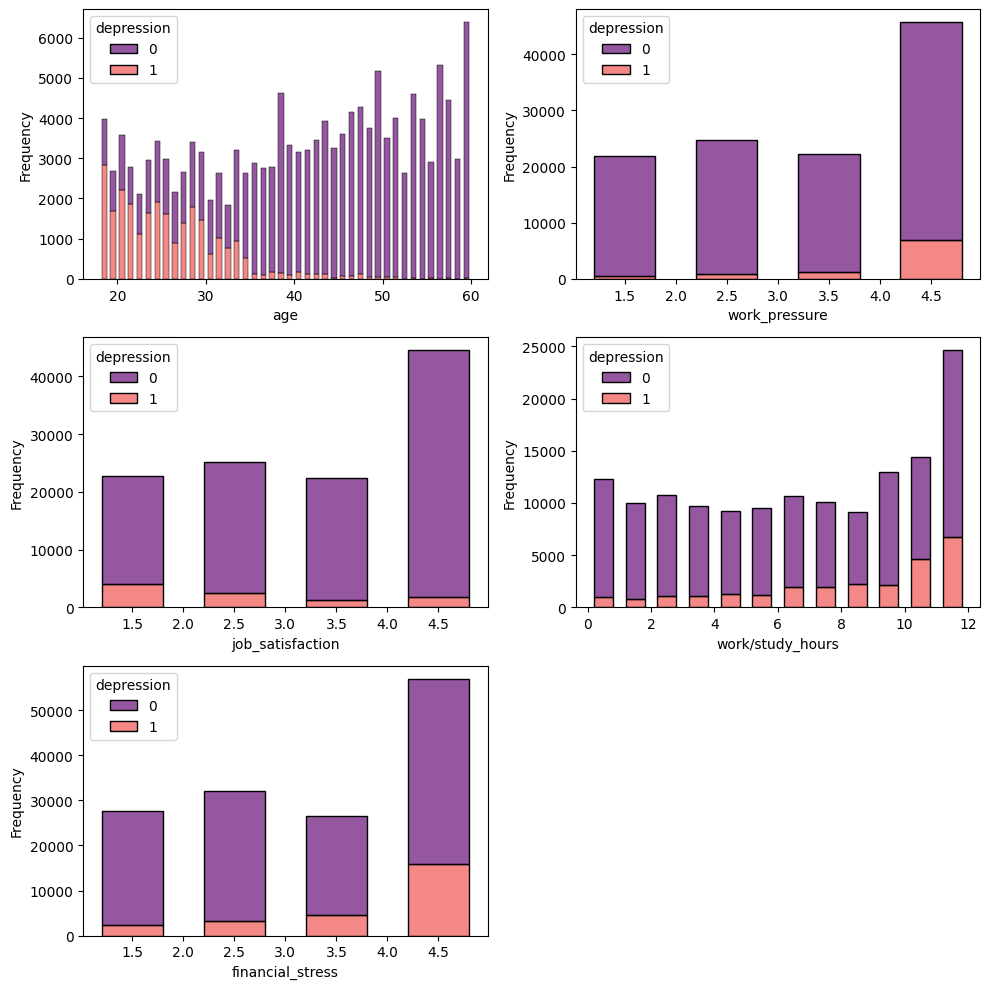

In [44]:

numerical_features = df.select_dtypes(include=['number'])

# Set the figure size
plt.figure(figsize=(10, 10))

# Define the number of rows and columns for 2 plots per row
num_features = len(numerical_features.columns) - 1  # Exclude the target column
num_cols = 2
num_rows = (num_features + 1) // num_cols  # Calculate the number of rows needed

# Loop through the numerical features, skipping the last column if it's the target column
for i, feature in enumerate(numerical_features.iloc[:, :-1], 1):  # Exclude the target column
    plt.subplot(num_rows, num_cols, i)  # Set up the subplot grid with 2 columns
    sns.histplot(df, x=feature, hue='depression', multiple='stack', palette='magma', binwidth=1, shrink=0.6)
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


**EDA** (series of histograms) for categorical features. Distribution of target variable compared to different categorical features.

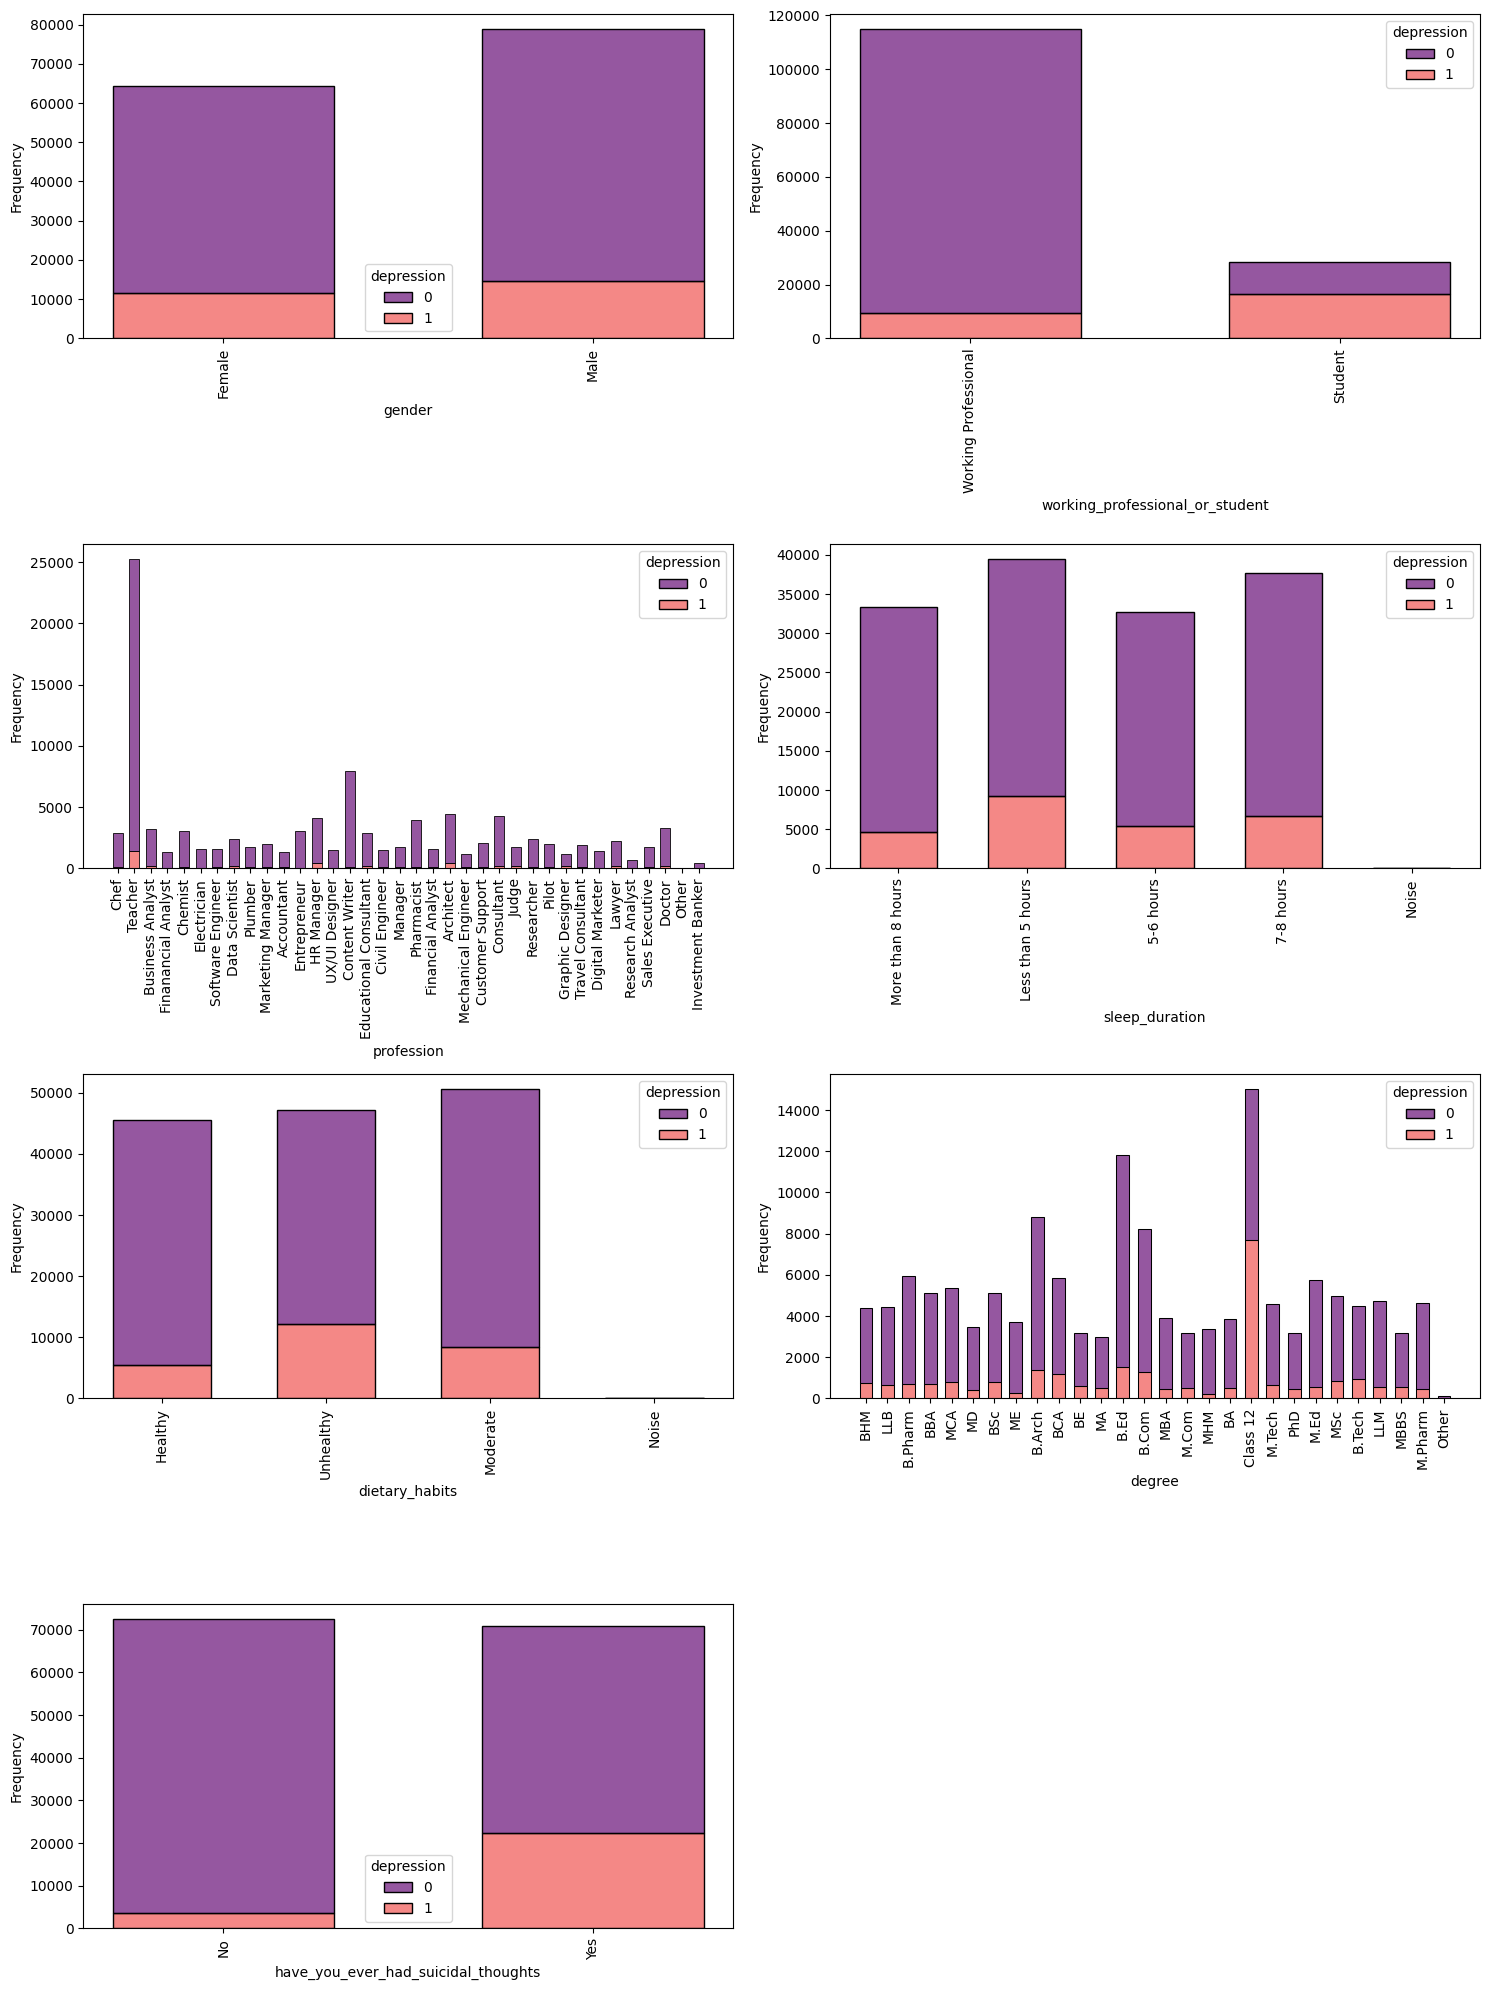

In [45]:
# Select categorical features
cat_c = df.select_dtypes(include=['object'])

# Set the figure size
plt.figure(figsize=(15, 20))
cat_col = len(cat_c.columns)
num_cols = 2
num_rows = (cat_col + 1) // num_cols  # Ensure enough rows for all columns

# Loop through the categorical features, skipping the last column if it's the target column
for i, feature in enumerate(cat_c.iloc[:, :-1], 1):  # Exclude the target column
    plt.subplot(num_rows, num_cols, i)  # Adjust the grid size based on the number of features
    sns.histplot(df, x=feature, hue='depression', multiple='stack', palette='magma', shrink=0.6)
    plt.xlabel(feature)
    plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
    plt.ylabel('Frequency')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


Converting the features '***work_pressure***', '***job_satisfaction***', and '***financial_stress***' to the object data type, even though their values seem to be numerical (like 1, 2, 3, 4, 5), these columns represent categorical variables rather than continuous numerical values.

In [46]:
df['work_pressure'] = df['work_pressure'].astype('str')
df['job_satisfaction'] = df['job_satisfaction'].astype('str')
df['financial_stress'] = df['financial_stress'].astype('str')


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143256 entries, 0 to 143255
Data columns (total 14 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   gender                               143256 non-null  object 
 1   age                                  143256 non-null  float64
 2   working_professional_or_student      143256 non-null  object 
 3   profession                           105953 non-null  object 
 4   work_pressure                        143256 non-null  object 
 5   job_satisfaction                     143256 non-null  object 
 6   sleep_duration                       143256 non-null  object 
 7   dietary_habits                       143256 non-null  object 
 8   degree                               143254 non-null  object 
 9   have_you_ever_had_suicidal_thoughts  143256 non-null  object 
 10  work/study_hours                     143256 non-null  float64
 11  financial_str

Filling  missing values of '***work_pressure***', '***job_satisfaction***', '***financial_stress***', '***degree***', '***profession***' (NaN) in the column with 'Unknown' value.

In [48]:
fill_with_unknown = ['work_pressure', 'job_satisfaction', 'financial_stress', 'degree', 'profession']

for col in fill_with_unknown:
    # Fill missing values with 'Unknown'
    df[col] = df[col].fillna('Unknown')


In [49]:
df.isna().sum()

,0
gender,0
age,0
working_professional_or_student,0
profession,0
work_pressure,0
job_satisfaction,0
sleep_duration,0
dietary_habits,0
degree,0
have_you_ever_had_suicidal_thoughts,0


# **Model Training**

Split the dataframe `df` into two sets: training and testing.
Since we have a moderate imbalanced data, it is better to apply stratify parametr, which will ensure that the class distribution in the training and test sets is proportional to the class distribution in the original dataset

In [50]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['depression'])

# Feature Importance
using mutual_info_score

In [51]:
from sklearn.metrics import mutual_info_score


categorical = df_full_train.select_dtypes(include=['object']).columns.to_list()

def mutual_info_depression_score(series):
    return mutual_info_score(series, df_full_train.depression)



mi = df_full_train[categorical].apply(mutual_info_depression_score)
mi.sort_values(ascending=False)

,0
profession,0.135597
work_pressure,0.131619
job_satisfaction,0.123983
working_professional_or_student,0.111760
have_you_ever_had_suicidal_thoughts,0.066055
degree,0.037903
financial_stress,0.026476
dietary_habits,0.011503
sleep_duration,0.004097
family_history_of_mental_illness,0.000150


Based on the mutual information scores between various features and the target variable, the most informative features for predicting the target are ***profession***, ***work_pressure***, ***job_satisfaction*** and ***working_professional_or_student***. These features show the highest mutual information scores, suggesting they have the strongest relationships with the target variable.

In [52]:
y = df_full_train.depression
X = df_full_train.drop('depression', axis=1)

**Stratified Cross-Validation** ensures that each fold maintains the same class distribution as the original dataset

In [53]:

def train_model(X, y, model):
    """
    Trains a model using cross-validation and calculates performance metrics.

    Parameters:
    - X: The features of the training data.
    - y: The target variable for the training data.
    - model: The machine learning model (e.g., RandomForestClassifier).

    Returns:
    - res: A dictionary with average accuracy, precision, recall, F1 score, and ROC AUC score.
    - dv: The trained DictVectorizer.
    """

    # Lists to store metrics
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

    # Cross-validation loop
    for fold, (train_index, val_index) in enumerate(skf.split(X, y), start=1):
        # Split data into training and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Transform the data using DictVectorizer (if categorical features exist)
        dv = DictVectorizer(sparse=False)
        X_train_dict = X_train.to_dict(orient='records')
        X_val_dict = X_val.to_dict(orient='records')
        X_train_transformed = dv.fit_transform(X_train_dict)
        X_val_transformed = dv.transform(X_val_dict)

        # Train the model
        model.fit(X_train_transformed, y_train)

        # Get predicted class labels and probabilities
        y_pred = model.predict(X_val_transformed)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred, average='binary')  # Use 'binary' or 'macro' depending on classification type
        recall = recall_score(y_val, y_pred, average='binary')
        f1 = f1_score(y_val, y_pred, average='binary')

        # Append metrics to the lists
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)


        # Print metrics for each fold
        print(f"Fold {fold} Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
              f"F1 Score: {f1:.4f}")

    # After all folds, aggregate results
    res = {
        'Average_Accuracy': sum(accuracy_scores) / len(accuracy_scores),
        'Average_Precision': sum(precision_scores) / len(precision_scores),
        'Average_Recall': sum(recall_scores) / len(recall_scores),
        'Average_F1': sum(f1_scores) / len(f1_scores),
    }

    return res, dv


# LogisticRegression

Start  with basic logistic regression as a baseline for the rest of the models. After all, it is the simplest regression.

In [ ]:
model_lr = LogisticRegression(max_iter=500, class_weight='balanced', random_state=1)
results_lr, dv_lr = train_model(X, y, model_lr)
results_lr, dv_lr

Fold 1 Accuracy: 0.9052, Precision: 0.6728, Recall: 0.9311, F1 Score: 0.7811
Fold 2 Accuracy: 0.9034, Precision: 0.6675, Recall: 0.9323, F1 Score: 0.7780
Fold 3 Accuracy: 0.9029, Precision: 0.6684, Recall: 0.9241, F1 Score: 0.7757
Fold 4 Accuracy: 0.9057, Precision: 0.6770, Recall: 0.9200, F1 Score: 0.7800
Fold 5 Accuracy: 0.9034, Precision: 0.6692, Recall: 0.9255, F1 Score: 0.7767


({'Average_Accuracy': 0.9041220135204515,
  'Average_Precision': 0.67097217816854,
  'Average_Recall': 0.9265988882897064,
  'Average_F1': 0.7783193182874347},
 DictVectorizer(sparse=False))

# RidgeClassifier

RidgeClassifier class, which is essentially a version of logistic regression with L2 regularization (ridge regularization). It is useful when you have many features and want to avoid overfitting by penalizing large coefficients.

In [ ]:
model_lr = RidgeClassifier(alpha=1.0)
results_ridge, dv_ridge = train_model(X, y, model_lr)
results_ridge, dv_ridge

Fold 1 Accuracy: 0.9175, Precision: 0.7890, Recall: 0.7459, F1 Score: 0.7669
Fold 2 Accuracy: 0.9185, Precision: 0.7942, Recall: 0.7454, F1 Score: 0.7690
Fold 3 Accuracy: 0.9206, Precision: 0.7981, Recall: 0.7543, F1 Score: 0.7755
Fold 4 Accuracy: 0.9201, Precision: 0.7952, Recall: 0.7557, F1 Score: 0.7749
Fold 5 Accuracy: 0.9201, Precision: 0.7968, Recall: 0.7528, F1 Score: 0.7742


({'Average_Accuracy': 0.9193396454762709,
  'Average_Precision': 0.7946409862435438,
  'Average_Recall': 0.7508275535341615,
  'Average_F1': 0.772110223717517},
 DictVectorizer(sparse=False))

**Ridge Classifier** showed slightly better results in terms of **accuracy** and **precision** metrics compared to other models tested, indicating its slightly superior performance on this dataset

# Ensemble Learning

Ensemble learning is a powerful technique in machine learning that combines the predictions of several base models to form a stronger and more accurate overall model. It harnesses the "wisdom of the crowd" concept, where multiple diverse models offer their insights to create a more robust and reliable prediction. The core idea of ensemble learning is that different models may perform better in different areas of a problem, and by aggregating their predictions, the ensemble can reduce the shortcomings of individual models.

# RandomForestClassifier

In [ ]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=1)
results_rf, dv_rf = train_model(X, y, model_rf)
results_rf, dv_rf

Fold 1 Accuracy: 0.9229, Precision: 0.8090, Recall: 0.7546, F1 Score: 0.7809
Fold 2 Accuracy: 0.9244, Precision: 0.8151, Recall: 0.7565, F1 Score: 0.7847
Fold 3 Accuracy: 0.9267, Precision: 0.8156, Recall: 0.7720, F1 Score: 0.7932
Fold 4 Accuracy: 0.9243, Precision: 0.8069, Recall: 0.7674, F1 Score: 0.7867
Fold 5 Accuracy: 0.9257, Precision: 0.8216, Recall: 0.7562, F1 Score: 0.7875


({'Average_Accuracy': 0.9248193860801038,
  'Average_Precision': 0.8136414196831641,
  'Average_Recall': 0.7613276899598722,
  'Average_F1': 0.7865863098372763},
 DictVectorizer(sparse=False))

# XGBoost Classifier

XGBoost is a gradient descent algorithm that was covered back in Lesson 6.

In [ ]:
model_xgb =  XGBClassifier(n_estimators=500, scale_pos_weight=1, random_state=1, eval_metric='logloss')
results_xgb, dv_xgb = train_model(X, y, model_xgb)
results_xgb, dv_xgb

Fold 1 Accuracy: 0.9255, Precision: 0.7973, Recall: 0.7908, F1 Score: 0.7940
Fold 2 Accuracy: 0.9249, Precision: 0.7942, Recall: 0.7917, F1 Score: 0.7930
Fold 3 Accuracy: 0.9250, Precision: 0.8007, Recall: 0.7817, F1 Score: 0.7911
Fold 4 Accuracy: 0.9250, Precision: 0.7996, Recall: 0.7839, F1 Score: 0.7917
Fold 5 Accuracy: 0.9274, Precision: 0.8038, Recall: 0.7944, F1 Score: 0.7991


({'Average_Accuracy': 0.9255785301102131,
  'Average_Precision': 0.7991381866834926,
  'Average_Recall': 0.7884907248638168,
  'Average_F1': 0.7937672346441097},
 DictVectorizer(sparse=False))

# CatBoost Classifier

CatBoost is also another powerful gradient boosting algorithm that is used in Machine Learning.

In [54]:
model_cat =  CatBoostClassifier(iterations=500, random_state=1, eval_metric='Logloss', silent=True)
results_cat, dv_cat = train_model(X, y, model_cat)
results_cat, dv_cat

Fold 1 Accuracy: 0.9297, Precision: 0.8092, Recall: 0.8018, F1 Score: 0.8055
Fold 2 Accuracy: 0.9298, Precision: 0.8115, Recall: 0.7992, F1 Score: 0.8053
Fold 3 Accuracy: 0.9291, Precision: 0.8137, Recall: 0.7908, F1 Score: 0.8021
Fold 4 Accuracy: 0.9294, Precision: 0.8157, Recall: 0.7899, F1 Score: 0.8026
Fold 5 Accuracy: 0.9330, Precision: 0.8230, Recall: 0.8042, F1 Score: 0.8135


({'Average_Accuracy': 0.9302031589190978,
  'Average_Precision': 0.8146195488423216,
  'Average_Recall': 0.7971856501733052,
  'Average_F1': 0.8057939489214141},
 DictVectorizer(sparse=False))

LightGBM (Light Gradient Boosting Machine) is a highly efficient, open-source implementation of the gradient boosting framework, designed specifically for speed and scalability. Developed by Microsoft, it is widely used for supervised machine learning tasks such as classification, regression, and ranking.

# LightGBM Classifier

In [ ]:
model_lgb = LGBMClassifier(n_estimators=500, random_state=1, verbosity=-1)

results_lgb, dv_lgb = train_model(X, y, model_lgb)

results_lgb, dv_lgb


Fold 1 Accuracy: 0.9305, Precision: 0.8097, Recall: 0.8066, F1 Score: 0.8082
Fold 2 Accuracy: 0.9276, Precision: 0.8018, Recall: 0.7989, F1 Score: 0.8004
Fold 3 Accuracy: 0.9282, Precision: 0.8098, Recall: 0.7906, F1 Score: 0.8001
Fold 4 Accuracy: 0.9293, Precision: 0.8154, Recall: 0.7894, F1 Score: 0.8022
Fold 5 Accuracy: 0.9317, Precision: 0.8165, Recall: 0.8049, F1 Score: 0.8107


({'Average_Accuracy': 0.9294614695608627,
  'Average_Precision': 0.8106730341950856,
  'Average_Recall': 0.7980984880527717,
  'Average_F1': 0.8043109479336386},
 DictVectorizer(sparse=False))

# OPTUNA

Optuna is an open-source hyperparameter optimization framework designed to automate the process of tuning machine learning models

- Efficient search algorithms, such as Tree-structured Parzen Estimators (TPE) and Gaussian Processes.
- Parallel optimization support, enabling the use of multiple machines or CPUs.
- Pruning capabilities to stop unpromising trials early, saving time and resources.

In [ ]:
def objective(trial, X, y):
    """
    Objective function for Optuna hyperparameter optimization.

    Parameters:
    - trial: Optuna trial object that defines the hyperparameter space.
    - X: Features for the training data.
    - y: Target variable for the training data.

    Returns:
    - Average accuracy for the given set of hyperparameters across folds.
    """
    # Define hyperparameters for CatBoost using the trial object
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  # Number of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  # Learning rate
        'depth': trial.suggest_int('depth', 4, 8),  # Depth of the trees
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),  # Regularization term
        #'border_count': trial.suggest_int('border_count', 32, 255),  # Number of splits
        'eval_metric': 'Logloss',  # Evaluation metric
        'random_state': 1,
        'silent': True  # Suppress verbose output
    }

    # Initialize the CatBoostClassifier with suggested parameters
    model = CatBoostClassifier(**param)

    # List to store accuracy scores
    accuracy_scores = []

    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

    # Cross-validation loop
    for train_index, val_index in skf.split(X, y):
        # Split data into training and validation sets
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Transform the data using DictVectorizer (if categorical features exist)
        dv = DictVectorizer(sparse=False)
        X_train_dict = X_train.to_dict(orient='records')
        X_val_dict = X_val.to_dict(orient='records')
        X_train_transformed = dv.fit_transform(X_train_dict)
        X_val_transformed = dv.transform(X_val_dict)

        # Train the model
        model.fit(X_train_transformed, y_train)

        # Get predicted class labels
        y_pred = model.predict(X_val_transformed)

        # Calculate accuracy for this fold
        accuracy = accuracy_score(y_val, y_pred)
        accuracy_scores.append(accuracy)

    # Return the average accuracy for the current set of hyperparameters
    return sum(accuracy_scores) / len(accuracy_scores)

def tune_hyperparameters(X, y):
    """
    Tunes hyperparameters for the CatBoostClassifier using Optuna.

    Parameters:
    - X: Features for the training data.
    - y: Target variable for the training data.

    Returns:
    - best_trial: The best trial (with the optimal hyperparameters).
    - best_params: The best hyperparameters found by Optuna.
    """
    # Set up the Optuna study to maximize the objective function (maximize accuracy)
    study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
    study.optimize(lambda trial: objective(trial, X, y), n_trials=25)  # 20 trials for hyperparameter search

    # Retrieve the best trial (best hyperparameters)
    best_trial = study.best_trial
    best_params = best_trial.params
    print(f"Best hyperparameters: {best_params}")
    print(f"Best accuracy: {best_trial.value}")

    return best_trial, best_params

# Example usage:
# X and y are your feature and target variables
best_trial, best_params = tune_hyperparameters(X, y)

# Optionally, you can retrain your model using the best parameters
best_model = CatBoostClassifier(**best_params)
dv = DictVectorizer(sparse=False)
X_dict = X.to_dict(orient='records')
X_transformed = dv.fit_transform(X_dict)
best_model.fit(X_transformed, y)

# Now you have the best model trained with optimized hyperparameters


[I 2024-11-21 11:42:58,394] A new study created in memory with name: no-name-77a6aedd-d4a8-427a-96cf-f992adbc916d
[I 2024-11-21 11:45:24,057] Trial 0 finished with value: 0.9307615987777428 and parameters: {'iterations': 857, 'learning_rate': 0.05507788702671673, 'depth': 6}. Best is trial 0 with value: 0.9307615987777428.
[I 2024-11-21 11:46:44,288] Trial 1 finished with value: 0.9287372379200948 and parameters: {'iterations': 304, 'learning_rate': 0.011573236530021862, 'depth': 7}. Best is trial 0 with value: 0.9307615987777428.
[I 2024-11-21 11:48:50,749] Trial 2 finished with value: 0.9307092499900829 and parameters: {'iterations': 563, 'learning_rate': 0.03856841822914148, 'depth': 8}. Best is trial 0 with value: 0.9307615987777428.
[I 2024-11-21 11:50:38,763] Trial 3 finished with value: 0.9309448368563606 and parameters: {'iterations': 555, 'learning_rate': 0.048739713817646475, 'depth': 6}. Best is trial 3 with value: 0.9309448368563606.
[I 2024-11-21 11:51:48,004] Trial 4 fini

Best hyperparameters: {'iterations': 819, 'learning_rate': 0.04405886196667592, 'depth': 4}
Best accuracy: 0.9311193595910622
0:	learn: 0.6225264	total: 49.7ms	remaining: 40.6s
1:	learn: 0.5629199	total: 97.8ms	remaining: 39.9s
2:	learn: 0.5120160	total: 152ms	remaining: 41.5s
3:	learn: 0.4699187	total: 209ms	remaining: 42.6s
4:	learn: 0.4343876	total: 270ms	remaining: 44s
5:	learn: 0.4051332	total: 327ms	remaining: 44.2s
6:	learn: 0.3811943	total: 382ms	remaining: 44.3s
7:	learn: 0.3589734	total: 436ms	remaining: 44.2s
8:	learn: 0.3410609	total: 501ms	remaining: 45s
9:	learn: 0.3255009	total: 554ms	remaining: 44.8s
10:	learn: 0.3122330	total: 598ms	remaining: 43.9s
11:	learn: 0.3007117	total: 649ms	remaining: 43.6s
12:	learn: 0.2897277	total: 709ms	remaining: 43.9s
13:	learn: 0.2802983	total: 765ms	remaining: 44s
14:	learn: 0.2719171	total: 825ms	remaining: 44.2s
15:	learn: 0.2642624	total: 878ms	remaining: 44.1s
16:	learn: 0.2584198	total: 935ms	remaining: 44.1s
17:	learn: 0.2525140	

In [56]:
model_cat_tuned = CatBoostClassifier(
    iterations=819,
    learning_rate=0.04405886196667592,
    depth=4,
    eval_metric='Logloss',
    random_state=1,
    silent=True  # Suppress output during training
)
results_cat_tuned, dv_cat_tuned= train_model(X, y, model_cat)
results_cat_tuned, dv_cat_tuned

Fold 1 Accuracy: 0.9297, Precision: 0.8092, Recall: 0.8018, F1 Score: 0.8055
Fold 2 Accuracy: 0.9298, Precision: 0.8115, Recall: 0.7992, F1 Score: 0.8053
Fold 3 Accuracy: 0.9291, Precision: 0.8137, Recall: 0.7908, F1 Score: 0.8021
Fold 4 Accuracy: 0.9294, Precision: 0.8157, Recall: 0.7899, F1 Score: 0.8026
Fold 5 Accuracy: 0.9330, Precision: 0.8230, Recall: 0.8042, F1 Score: 0.8135


({'Average_Accuracy': 0.9302031589190978,
  'Average_Precision': 0.8146195488423216,
  'Average_Recall': 0.7971856501733052,
  'Average_F1': 0.8057939489214141},
 DictVectorizer(sparse=False))

Model Training with the best hyperparametrs

In [66]:
X.columns.to_list()

['gender',
 'age',
 'working_professional_or_student',
 'profession',
 'work_pressure',
 'job_satisfaction',
 'sleep_duration',
 'dietary_habits',
 'degree',
 'have_you_ever_had_suicidal_thoughts',
 'work/study_hours',
 'financial_stress',
 'family_history_of_mental_illness']

In [70]:
test = X.iloc[[1]]
test.to_dict(orient='records')

[{'gender': 'Female',
  'age': 40.0,
  'working_professional_or_student': 'Working Professional',
  'profession': 'Researcher',
  'work_pressure': '3.0',
  'job_satisfaction': '3.0',
  'sleep_duration': 'Less than 5 hours',
  'dietary_habits': 'Healthy',
  'degree': 'B.Tech',
  'have_you_ever_had_suicidal_thoughts': 'Yes',
  'work/study_hours': 3.0,
  'financial_stress': '3.0',
  'family_history_of_mental_illness': 'Yes'}]

In [57]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction import DictVectorizer

# Lists to store metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
feature_importances_list = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation

# Initialize CatBoostClassifier with the specified hyperparameters
model_cat_tuned = CatBoostClassifier(
    iterations=819,
    learning_rate=0.04405886196667592,
    depth=4,
    eval_metric='Logloss',  # You can change this depending on your objective
    random_state=1,
    silent=True  # Suppress output during training
)

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(skf.split(X, y), start=1):
    # Split data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Transform the data using DictVectorizer (if categorical features exist)
    dv_cat_tuned = DictVectorizer(sparse=False)
    X_train_dict = X_train.to_dict(orient='records')
    X_val_dict = X_val.to_dict(orient='records')
    X_train_transformed = dv_cat_tuned.fit_transform(X_train_dict)
    X_val_transformed = dv_cat_tuned.transform(X_val_dict)

    # Train the CatBoost model
    model_cat_tuned.fit(X_train_transformed, y_train)

    # Get predicted class labels
    y_pred = model_cat_tuned.predict(X_val_transformed)

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='binary')  # Use 'binary' or 'macro' depending on classification type
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')

    # Append metrics to the lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Capture feature importances for this fold
    feature_importances = model_cat_tuned.feature_importances_
    feature_importances_list.append(feature_importances)

    # Print metrics for each fold
    print(f"Fold {fold} Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1 Score: {f1:.4f}")

# After all folds, aggregate results
res = {
    'Average_Accuracy': sum(accuracy_scores) / len(accuracy_scores),
    'Average_Precision': sum(precision_scores) / len(precision_scores),
    'Average_Recall': sum(recall_scores) / len(recall_scores),
    'Average_F1': sum(f1_scores) / len(f1_scores),
}

# Print the overall performance metrics
print("\nAverage Metrics across all folds:")
print(f"Average Accuracy: {res['Average_Accuracy']:.4f}")
print(f"Average Precision: {res['Average_Precision']:.4f}")
print(f"Average Recall: {res['Average_Recall']:.4f}")
print(f"Average F1 Score: {res['Average_F1']:.4f}")

# Optionally, you can also aggregate the feature importances
average_feature_importance = sum(feature_importances_list) / len(feature_importances_list)
print("\nAverage Feature Importances:")
print(average_feature_importance)


Fold 1 Accuracy: 0.9307, Precision: 0.8144, Recall: 0.8009, F1 Score: 0.8076
Fold 2 Accuracy: 0.9304, Precision: 0.8118, Recall: 0.8028, F1 Score: 0.8072
Fold 3 Accuracy: 0.9295, Precision: 0.8166, Recall: 0.7894, F1 Score: 0.8028
Fold 4 Accuracy: 0.9308, Precision: 0.8213, Recall: 0.7913, F1 Score: 0.8060
Fold 5 Accuracy: 0.9342, Precision: 0.8271, Recall: 0.8064, F1 Score: 0.8166

Average Metrics across all folds:
Average Accuracy: 0.9311
Average Precision: 0.8182
Average Recall: 0.7981
Average F1 Score: 0.8080

Average Feature Importances:
[3.66358662e+01 8.34709944e-03 2.33081025e-02 7.14228881e-02
 1.43162534e-03 3.04997455e-02 2.60237644e-02 6.85801391e-03
 1.25895923e-02 1.43990085e-01 4.42301003e-02 8.37868440e-02
 9.07770752e-02 7.71492557e-02 7.86057880e-02 1.53969524e-02
 1.27281082e-02 3.58013589e-02 1.00356673e-01 6.81176905e-02
 6.86806398e-02 4.47094354e-02 8.34383164e-03 1.81386343e-02
 1.50369044e-02 1.74853305e-02 2.40814137e-02 4.03217799e-03
 1.23459564e-01 9.377915

In [59]:
# Aggregate feature importances (average across folds)
average_feature_importances = np.mean(feature_importances_list, axis=0)

# Get feature names from DictVectorizer
feature_names = dv_cat_tuned.get_feature_names_out()

# Create a DataFrame to combine feature names with their importance values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': average_feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Feature Importance:\n", importance_df)

Feature Importance:
                                     Feature  Importance
0                                       age   36.635866
43   have_you_ever_had_suicidal_thoughts=No   12.069847
44  have_you_ever_had_suicidal_thoughts=Yes    7.096059
93                         work/study_hours    4.182674
39                     financial_stress=5.0    3.346715
..                                      ...         ...
92                     sleep_duration=Noise    0.002965
4                            degree=B.Pharm    0.001432
40                     financial_stress=nan    0.001275
66           profession=Finanancial Analyst    0.001233
76                         profession=Other    0.000402

[102 rows x 2 columns]


<ipython-input-60-eed7ddd43ee9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


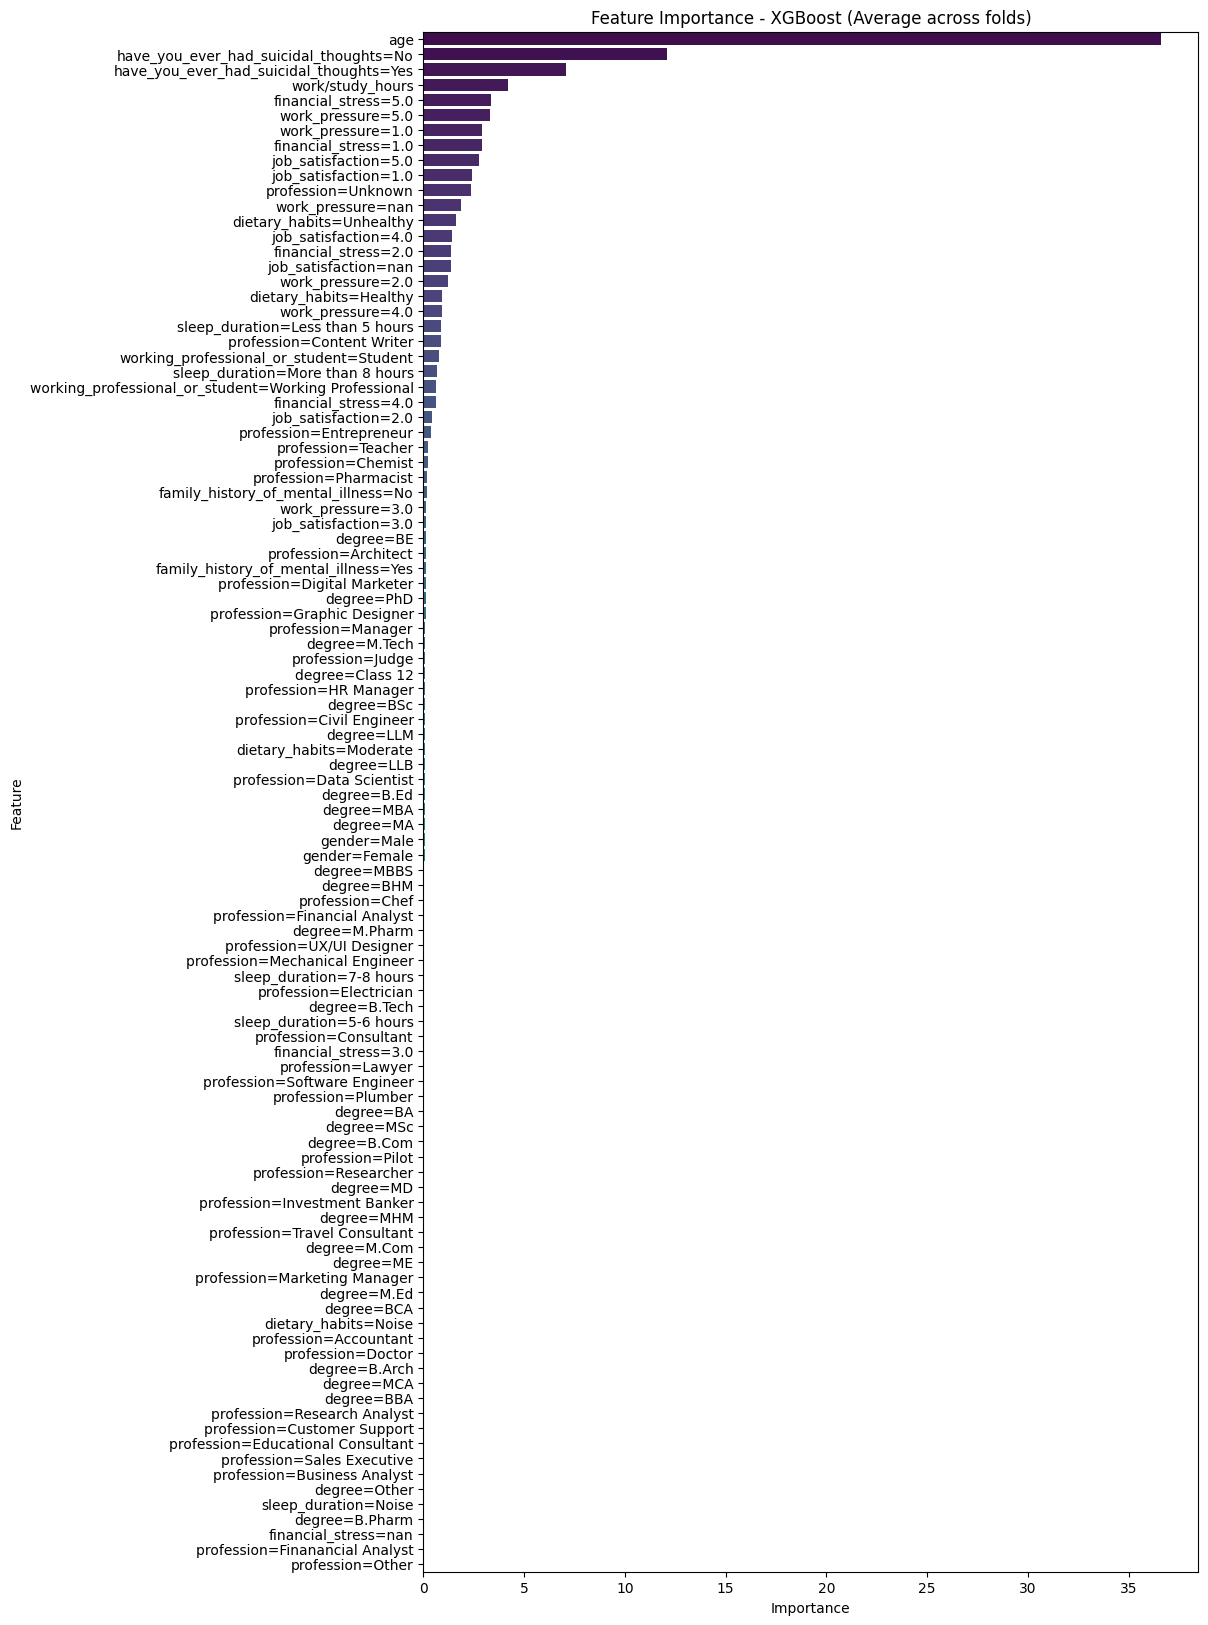

In [60]:
plt.figure(figsize=(10, 20))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance - XGBoost (Average across folds)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [62]:
with open('catboost_model.pkl', 'wb') as model_file:
    pickle.dump(model_cat_tuned, model_file)

with open('dictvectorizer.pkl', 'wb') as dv_file:
    pickle.dump(dv_cat_tuned, dv_file)

In [63]:
with open('catboost_model.pkl', 'rb') as model_file:
    loaded_model_cat = pickle.load(model_file)

with open('dictvectorizer.pkl', 'rb') as dv_file:
    loaded_dv_cat = pickle.load(dv_file)

print("Model and DictVectorizer have been loaded from files.")

Model and DictVectorizer have been loaded from files.


In [ ]:
need_columns = df_full_train.columns.to_list()

In [ ]:
df_test['depression'].head(15)

,depression
115489,0
138706,1
62668,0
135151,0
94765,0
54918,1
53777,0
55298,1
39996,0
123617,0


In [ ]:
df_test = df_test.drop('depression', axis=1)

In [ ]:
df_test_dict = df_test.to_dict(orient='records')
df_test_transform = loaded_dv_xgb.transform(df_test_dict)
df_test_transform[:5]

array([[48.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  2.,  0.,  0.,  1.],
       [20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  5.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  9

In [ ]:
y_pred = loaded_model_xgb.predict(df_test_transform[:15])
y_pred

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_pred = loaded_model_xgb.predict_proba(df_test_transform[:15])[:, 1]
y_pred.round(2)

array([0.  , 0.99, 0.  , 0.  , 0.03, 0.85, 0.  , 0.75, 0.21, 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.01], dtype=float32)

In [ ]:
df_test.head()

,gender,age,working_professional_or_student,profession,work_pressure,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work/study_hours,financial_stress,family_history_of_mental_illness
115489,Male,48.0,Working Professional,Chef,2.0,1.0,Less than 5 hours,Healthy,BHM,No,2.0,1.0,No
138706,Female,20.0,Working Professional,Unknown,5.0,1.0,7-8 hours,Unhealthy,Class 12,Yes,9.0,5.0,Yes
62668,Female,60.0,Working Professional,Teacher,5.0,2.0,Less than 5 hours,Unhealthy,B.Tech,No,5.0,2.0,No
135151,Female,59.0,Working Professional,Data Scientist,3.0,3.0,Less than 5 hours,Moderate,ME,No,2.0,1.0,Yes
94765,Male,50.0,Working Professional,Lawyer,5.0,3.0,7-8 hours,Moderate,LLM,Yes,9.0,4.0,No


In [ ]:
df_full_train.columns.to_list()

['gender',
 'age',
 'working_professional_or_student',
 'profession',
 'work_pressure',
 'job_satisfaction',
 'sleep_duration',
 'dietary_habits',
 'degree',
 'have_you_ever_had_suicidal_thoughts',
 'work/study_hours',
 'financial_stress',
 'family_history_of_mental_illness',
 'depression']

In [ ]:
df_test.head()

,gender,age,working_professional_or_student,profession,work_pressure,job_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,work/study_hours,financial_stress,family_history_of_mental_illness,depression
115489,Male,48.0,Working Professional,Chef,2.0,1.0,Less than 5 hours,Healthy,BHM,No,2.0,1.0,No,0
138706,Female,20.0,Working Professional,Teacher,5.0,1.0,7-8 hours,Unhealthy,Class 12,Yes,9.0,5.0,Yes,1
62668,Female,60.0,Working Professional,Teacher,5.0,2.0,Less than 5 hours,Unhealthy,B.Tech,No,5.0,2.0,No,0
135151,Female,59.0,Working Professional,Data Scientist,3.0,3.0,Less than 5 hours,Moderate,ME,No,2.0,1.0,Yes,0
94765,Male,50.0,Working Professional,Lawyer,5.0,3.0,7-8 hours,Moderate,LLM,Yes,9.0,4.0,No,0


In [ ]:
first_row = df_test.iloc[:5, :]
first_row
first_row_transformed = dv_xgb.transform(first_row.to_dict(orient='records'))
first_row_predict = model_xgb.predict(first_row_transformed)
first_row_predict

array([0, 1, 0, 0, 0])